In [33]:
!pip install neo4j sentence_transformers pandas nltk hdbscan spacy matplotlib wordcloud pyLDAvis

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Build our dataset from Neo4j

In [34]:
import os
import warnings

warnings.filterwarnings("ignore")

NEO4J_URI = "bolt://neo4j.neo4j.svc.cluster.local"
NEO4J_PASSWORD = os.getenv("NEO4J_PASSWORD")
NEO4J_DATABASE = 'neo4j'

In [35]:
from neo4j import GraphDatabase
auth = ("neo4j", NEO4J_PASSWORD)
with GraphDatabase.driver(NEO4J_URI, auth=auth) as driver:
    driver.verify_connectivity()

In [36]:
import pandas as pd

# Function to execute the query and return results as a pandas DataFrame
def get_chat_logs_as_dataframe(driver):
    query = """
    MATCH (m:Message)-[:POSTED_IN]->(c:Channel), (u:User)-[:SENT]->(m)
    OPTIONAL MATCH (m)-[:MENTIONED]->(mentioned:User)
    RETURN u.name AS user, c.name AS channel, m.timestamp AS timestamp, m.content AS message
    ORDER BY m.timestamp DESC
    """
    
    # Execute the query
    with driver.session(database="neo4j") as session:
        results = session.run(query)
        
        # Convert results to a DataFrame
        chat_logs_df = pd.DataFrame([record.data() for record in results])
        
        # Optionally, you can save the DataFrame to a CSV file for easy use
        chat_logs_df.to_csv("chat_logs.csv", index=False)
        
        print("Chat logs saved to chat_logs.csv")
        
        return chat_logs_df

# Call the function to get chat logs as a pandas DataFrame
chat_logs_df = get_chat_logs_as_dataframe(driver)

Chat logs saved to chat_logs.csv


# Break the chat logs into conversational contexts

## Possible Approaches:

1. **Clustering**: Use Clustering algorithms to group the chat logs into conversational contexts,
like K-Means or DBSCAN. We'll use the `message` column as the feature to cluster on.
2. **Time-based**: Group chat logs based on a time window, like every 5 minutes.
3. **User-based**: Group chat logs based on the user who sent the message.
4. **Channel-based**: Group chat logs based on the channel where the message was posted.
5. **Sequential**: Group chat logs based on the order they were posted.
6. **Sequence Labeling**: Use Sequence Labeling models to predict the start and end of each conversation, like Named Entity Recognition (NER) models, Conditional Random Fields (CRFs), Hidden Markov Model (HMM) or Long Short-Term Memory (LSTM) networks to label each message with a conversation ID. To do this, we need to train our model on labeled data to learn the conversational patterns that distinguish between different conversational threads. We can use this model to label new messages automatically.
7. **Transformer Based Methods**: Use transformer-based models like BERT, GPT-2, or RoBERTa to generate embeddings for each message and cluster them based on the embeddings.

# Data Preprocessing and Cleaning

In [37]:
# Basic text cleaning and preprocessing
# You might want to expand this with more sophisticated cleaning
chat_logs_df['message_clean'] = chat_logs_df['message'].str.lower().str.replace('[^\w\s]', '', regex=True)

## Remove stop words

In [38]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
from nltk.corpus import stopwords

stop = stopwords.words('english')
chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

## Lemmatization

Lemmatization is the process of converting a word to its base form. It's more sophisticated than stemming because it takes into account the context of the word.

In [40]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize_text(text):
    return ' '.join([token.lemma_ for token in nlp(text)])

chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lemmatize_text)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Removing frequent but unimportant words

In [41]:
# build frequent_words
from collections import Counter

# Tokenize the cleaned messages into lists of words
chat_logs_df['tokens'] = chat_logs_df['message_clean'].str.split()

# Flatten the list of token lists into a single list
all_words = [word for tokens in chat_logs_df['tokens'] for word in tokens]

# Count the words
word_counts = Counter(all_words)

# Set a frequency threshold
frequency_threshold = 100  # This is just an example value

# Filter words that meet or exceed the threshold
frequent_words = {word for word, count in word_counts.items() if count >= frequency_threshold}

chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in frequent_words]))

## Removing rare words

In [42]:
# Set a frequency threshold for rare words
#rare_threshold = 2  # Example: words appearing 2 times or less

# Filter words that are equal to or below the threshold
#rare_words = {word for word, count in word_counts.items() if count <= rare_threshold}

#chat_logs_df['message_clean'] = chat_logs_df['message_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in rare_words]))


## Generate embeddings

In [43]:
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize

model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings
message_embeddings = model.encode(chat_logs_df['message_clean'].tolist(), show_progress_bar=True)
print("Embeddings generated successfully!")

# verify the shape of the embeddings
print(message_embeddings)


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Embeddings generated successfully!
[[-0.00568745 -0.02389716  0.02173399 ... -0.00162619  0.00290608
   0.028416  ]
 [-0.07239271  0.0224806  -0.04757497 ... -0.04041902 -0.10670244
   0.01439249]
 [-0.04964655  0.01536404 -0.04788371 ... -0.04713265 -0.00467968
  -0.01725898]
 ...
 [-0.03119157  0.01449915 -0.04481908 ... -0.01519592  0.0967582
   0.09199005]
 [-0.10109375  0.04632897  0.04294023 ... -0.03402776 -0.01960466
   0.02392808]
 [-0.05801129 -0.04718682 -0.06704102 ...  0.01050268  0.06473238
   0.03528643]]


## Cluster the embeddings

In [44]:
import hdbscan

# Normalize embeddings to improve clustering
message_embeddings_normalized = normalize(message_embeddings)

# Clustering with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
cluster_labels = clusterer.fit_predict(message_embeddings_normalized)

# Add cluster labels to your DataFrame
chat_logs_df['cluster'] = cluster_labels


## Analyze the clusters

In [45]:
# Explore the number of messages per cluster
print(chat_logs_df['cluster'].value_counts())

# Inspect a specific cluster
#print(chat_logs_df[chat_logs_df['cluster'] == 0])

# Group the DataFrame by the 'cluster' column
grouped_df = chat_logs_df.groupby('cluster')

# Iterate through each group
for cluster_label, group in grouped_df:
    print(f"Cluster: {cluster_label}")
    print(group)  # 'group' is a DataFrame containing only the rows from this cluster
    # You can perform further analysis or processing on each group here


cluster
-1     1460
 29      71
 40      34
 42      26
 30      23
 39      18
 28      18
 9       15
 23      15
 26      14
 41      14
 6       14
 4       13
 7       12
 44      11
 27      10
 1       10
 21       9
 3        9
 31       9
 8        8
 0        8
 45       8
 17       8
 25       8
 15       8
 33       8
 12       8
 2        7
 13       7
 11       7
 35       7
 16       7
 38       7
 10       7
 20       6
 24       6
 37       6
 36       6
 22       6
 34       6
 5        6
 19       6
 14       6
 18       5
 32       5
 43       5
Name: count, dtype: int64
Cluster: -1
          user   channel                         timestamp  \
1          FE2  #!chases  2024-04-10T23:40:04.384959+00:00   
2      Raccoon  #!chases  2024-04-10T23:39:23.120387+00:00   
4     ballsbot  #!chases  2024-04-10T23:38:47.767155+00:00   
8       Scaleb  #!chases  2024-04-10T23:28:12.707331+00:00   
12      Scaleb  #!chases  2024-04-10T23:27:44.808837+00:00   
...        ...    

## Sample messages from each cluster

In [46]:
for cluster in sorted(chat_logs_df['cluster'].unique()):
    print(f"Cluster {cluster}:")
    sample_texts = chat_logs_df[chat_logs_df['cluster'] == cluster]['message'].sample(n=5)
    for text in sample_texts:
        print(f"- {text}")
    print("\n")


Cluster -1:
- Council on Foreign Relations (CFR) or the International Crisis Group offer in-depth analyses.
- sig: you're sick
- sig: why is everyone in here in the middle of the day, don't they have fucking jobs and non-stop back to back calls like i do
- complexity and environment of your application.
- I feel like my approach is safer than putting t bait out


Cluster 0:
- File:** - More structured; includes sections to organize settings. - INI files can have multiple sections, each denoted by square brackets `[Section]`, which group related settings. - Used for configuration options that require hierarchy and additional context. - Syntax includes sections and key-value pairs within those sections:  ``` [database] user=admin password=secret path=/usr/local/database 
- sig: what is .env file format?
- `.env` files are used to store environment variables for a project. This format helps in managing settings that should be kept out of the codebase for security or configuration reasons.

## Keyword and Phrase analysis

In [47]:
from collections import Counter

for cluster in sorted(chat_logs_df['cluster'].unique()):
    words = [word for message in chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean'] for word in message.split()]
    word_counts = Counter(words)
    print(f"Cluster {cluster} common words: {word_counts.most_common(10)}")


Cluster -1 common words: [('let', 78), ('keep', 71), ('you', 67), ('re', 60), ('go', 56), ('that', 52), ('one', 49), ('I', 49), ('m', 48), ('draw', 46)]
Cluster 0 common words: [('file', 12), ('section', 7), ('use', 6), ('env', 6), ('format', 6), ('ini', 5), ('configuration', 5), ('environment', 5), ('variable', 5), ('setting', 3)]
Cluster 1 common words: [('netherlands', 10), ('country', 5), ('kingdom', 5), ('mainland', 4), ('size', 4), ('maryland', 4), ('islands', 3), ('caribbean', 3), ('constituent', 3), ('sint', 3)]
Cluster 2 common words: [('fart', 7), ('pass', 4), ('someone', 3), ('smell', 3), ('draw', 2), ('rip', 1), ('day', 1), ('man', 1), ('try', 1), ('push', 1)]
Cluster 3 common words: [('twittercom', 9), ('error', 5), ('429', 4), ('many', 4), ('request', 4)]
Cluster 4 common words: [('1', 8), ('number', 7), ('list', 5), ('digit', 5), ('please', 4), ('follow', 4), ('zero', 4), ('42', 3), ('100100', 2), ('200', 2)]
Cluster 5 common words: [('bland', 6), ('discuss', 2), ('someo

In [48]:
## Cluster size distribution

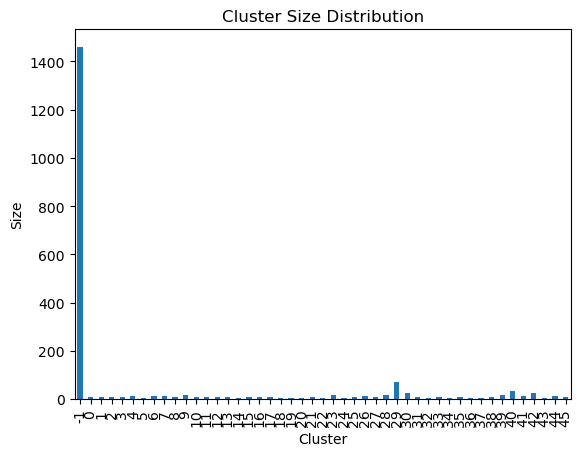

In [49]:
import matplotlib.pyplot as plt

cluster_sizes = chat_logs_df.groupby('cluster').size()
cluster_sizes.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Cluster Size Distribution')
plt.show()


## Word Clouds

Number of unique clusters: 47


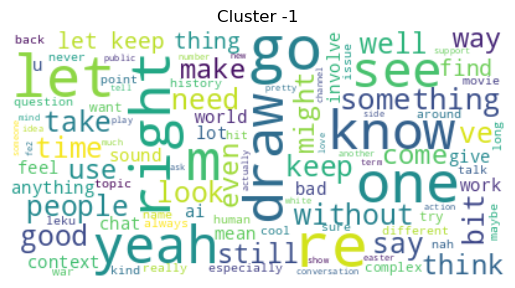

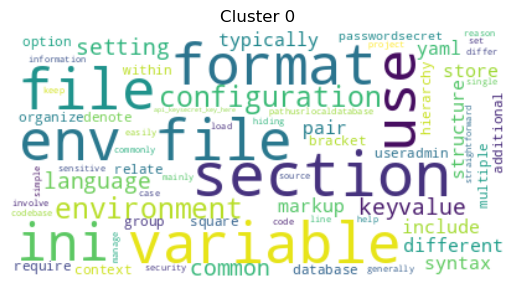

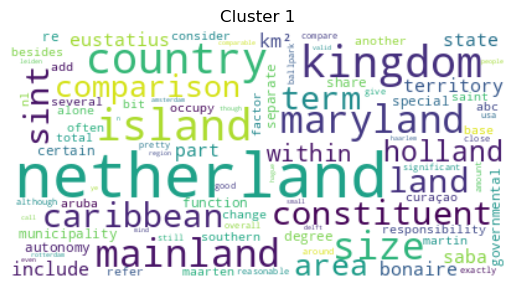

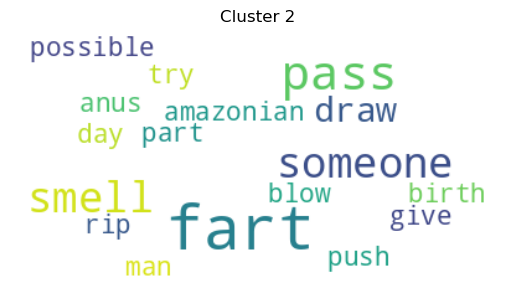

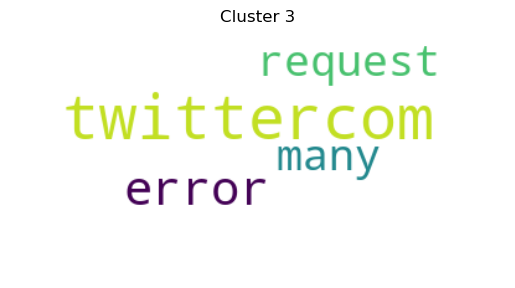

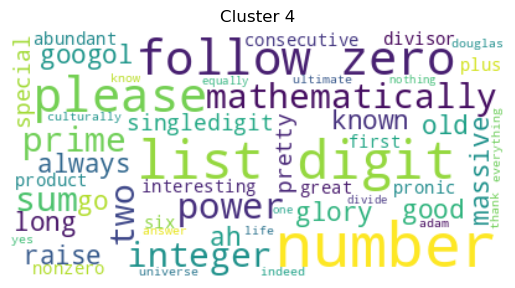

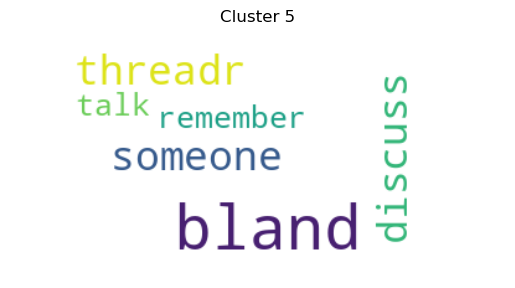

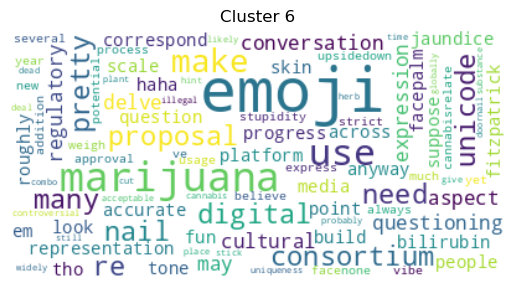

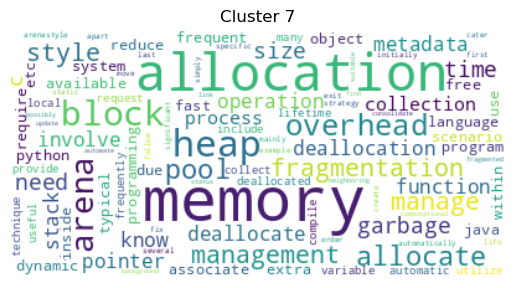

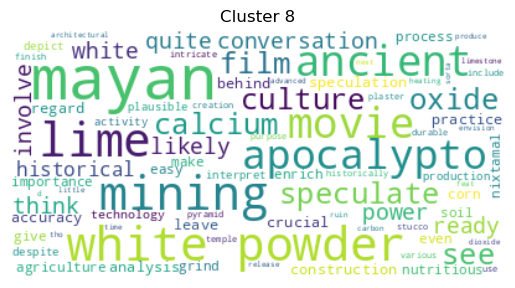

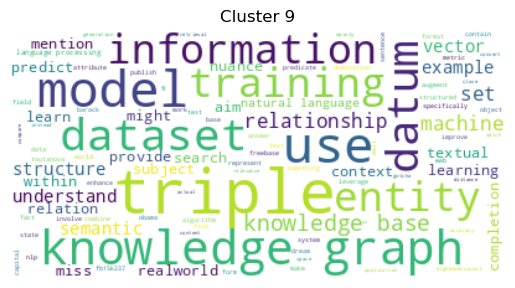

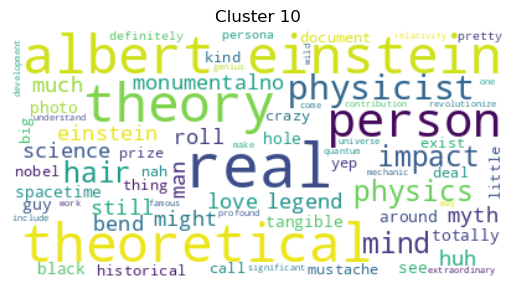

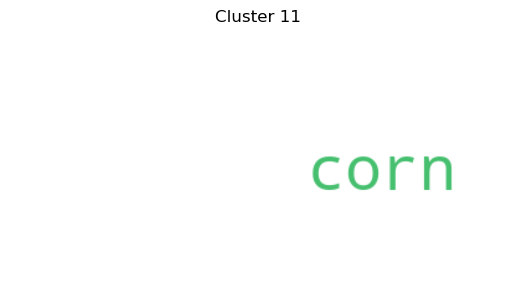

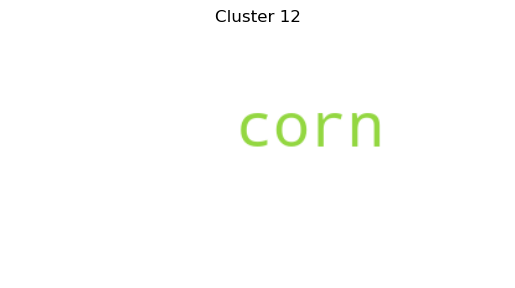

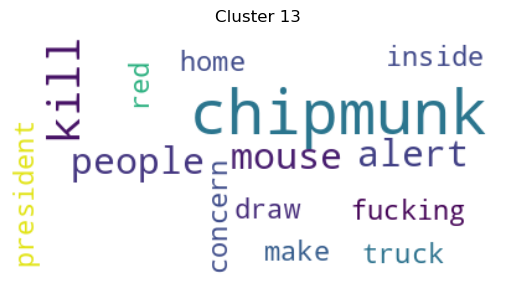

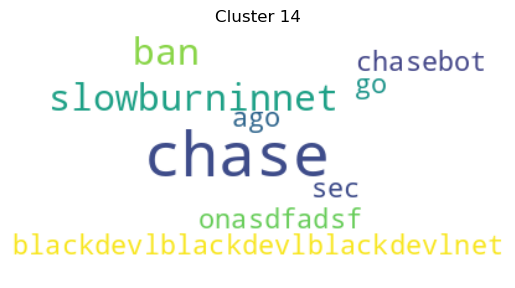

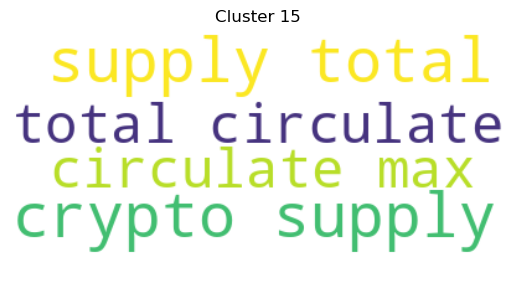

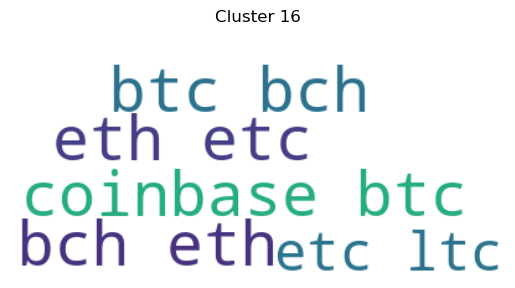

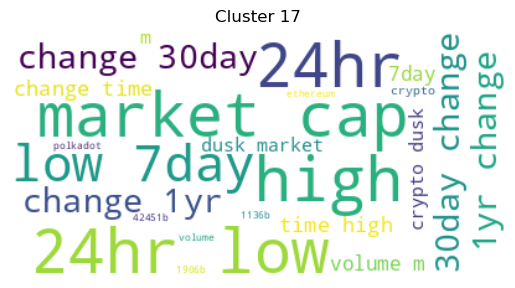

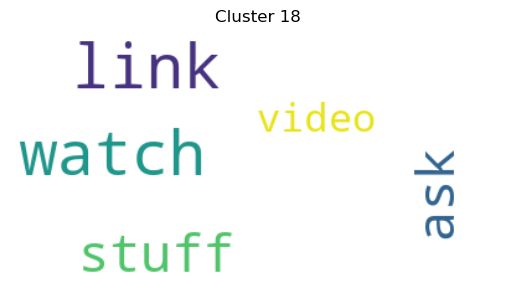

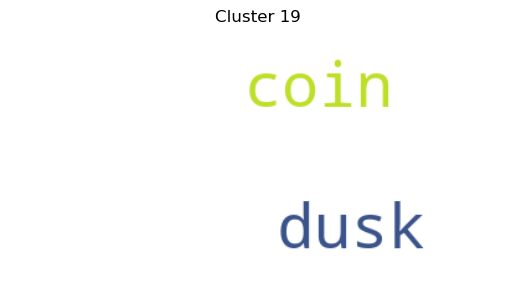

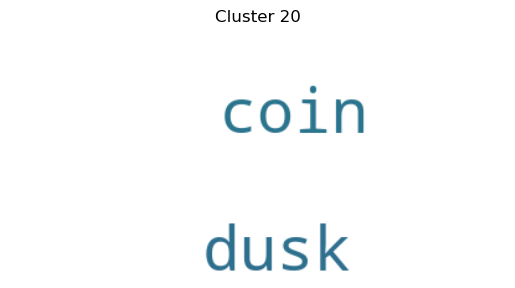

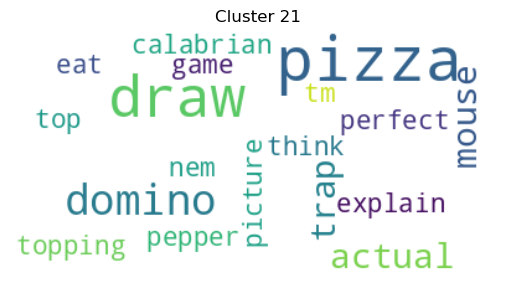

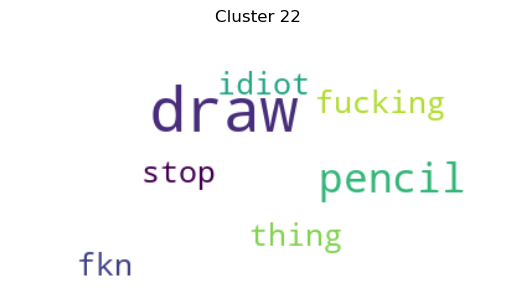

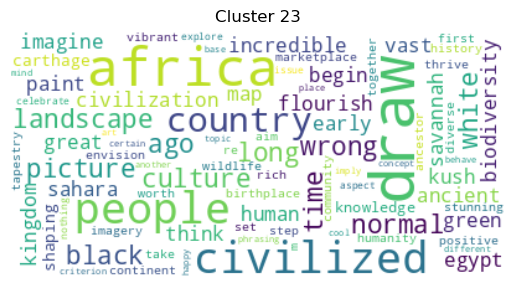

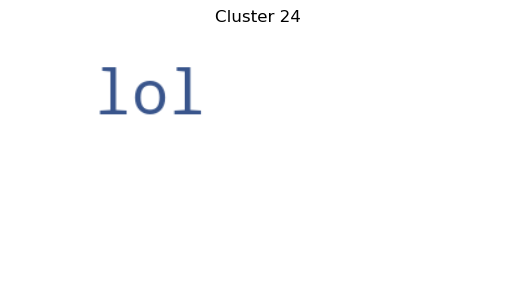

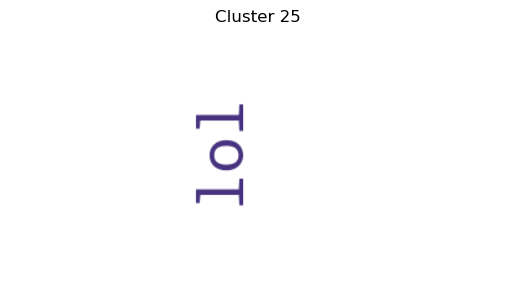

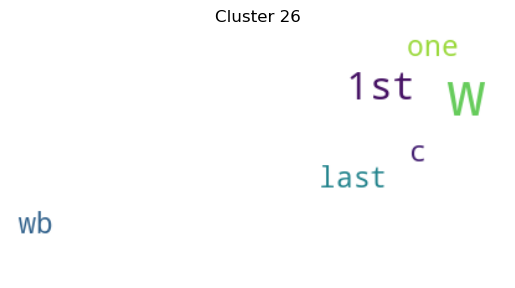

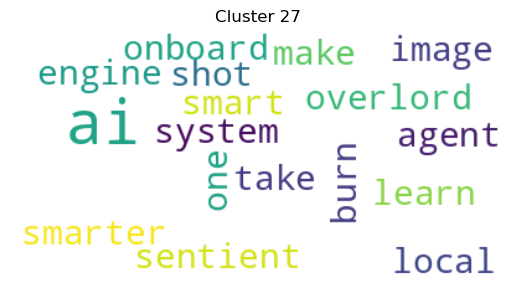

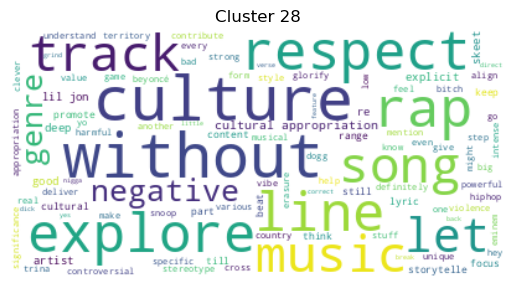

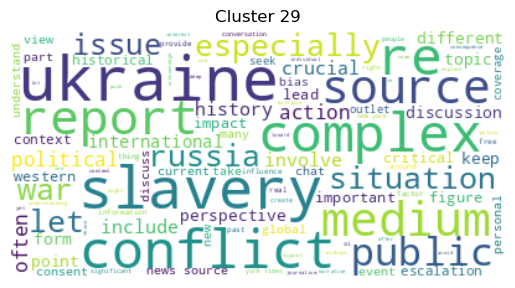

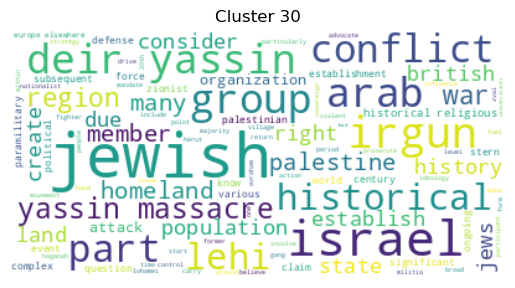

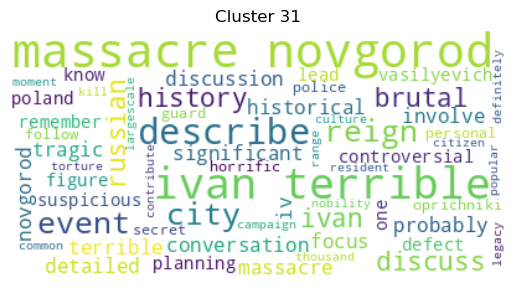

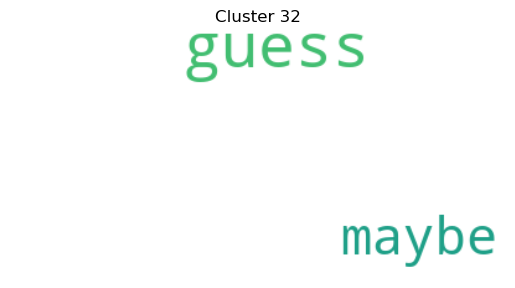

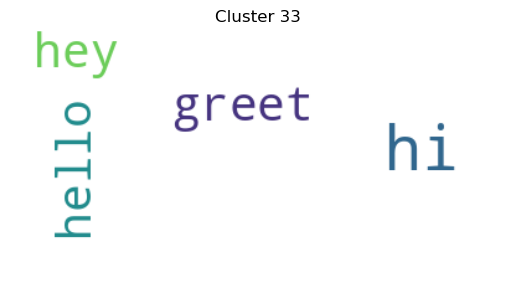

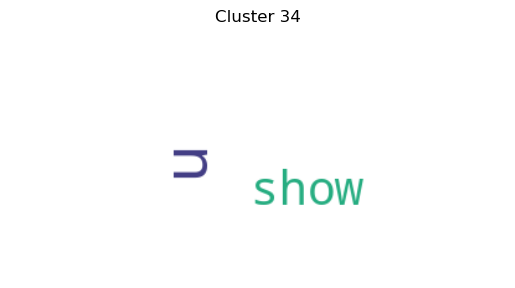

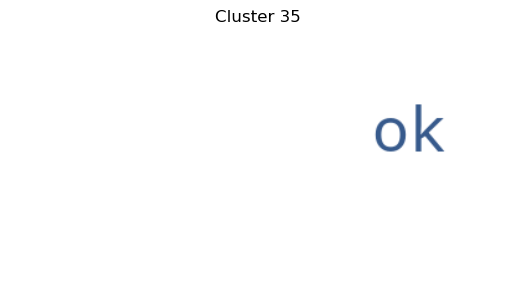

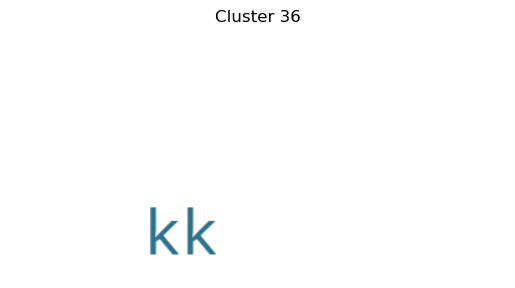

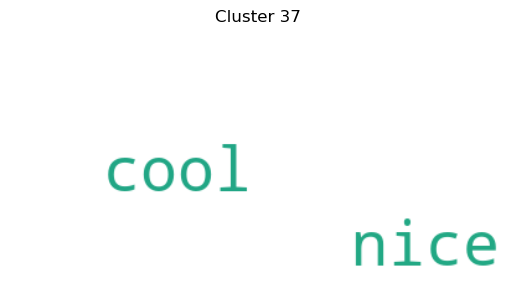

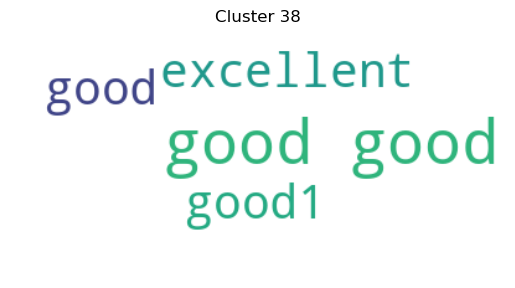

ValueError: We need at least 1 word to plot a word cloud, got 0.

In [50]:
from wordcloud import WordCloud

print(f"Number of unique clusters: {len(chat_logs_df['cluster'].unique())}")

for cluster in sorted(chat_logs_df['cluster'].unique()):
    text = " ".join(message for message in chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean'])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Cluster {cluster}")
    plt.show()


## Topic Modeling

Apply topic modeling techniques like Latent Dirichlet Allocation (LDA) within each cluster to discover subtopics.

In [51]:
for cluster in sorted(chat_logs_df['cluster'].unique()):
    texts = chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean']
    print(f"Cluster {cluster} has {len(texts)} texts.")
    if len(texts) > 0:
        print(f"Sample text: {texts.iloc[0]}")
    else:
        print("No texts in this cluster.")


Cluster -1 has 1460 texts.
Sample text: naw lago black
Cluster 0 has 8 texts.
Sample text: file structure include section organize setting ini file multiple section denote square bracket section group relate setting use configuration option require hierarchy additional context syntax include section keyvalue pair within section database useradmin passwordsecret pathusrlocaldatabase
Cluster 1 has 10 texts.
Sample text: islands caribbean netherlands special municipality netherlands separate country within kingdom territory degree autonomy they re part kingdom share certain governmental function responsibility netherland
Cluster 2 has 7 texts.
Sample text: rip fart day
Cluster 3 has 9 texts.
Sample text: 429 many request twittercom
Cluster 4 has 13 texts.
Sample text: please list digit 1000000000100000000010000000001000000000
Cluster 5 has 6 texts.
Sample text: bland
Cluster 6 has 14 texts.
Sample text: 3 questioning marijuana emojis conversation may delve cultural regulatory aspect digit

In [52]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer


n_topics = 200  # Adjust based on your dataset
#vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words='english')
#vectorizer = CountVectorizer(stop_words='english', min_df=1)
vectorizer = CountVectorizer(stop_words='english')

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

for cluster in sorted(chat_logs_df['cluster'].unique()):
    texts = chat_logs_df[chat_logs_df['cluster'] == cluster]['message_clean']
    if len(texts) == 0:
        continue  # Skip clusters with no texts
    try:
        dtm = vectorizer.fit_transform(texts)
        lda = LatentDirichletAllocation(n_components=5, random_state=0)
        lda.fit(dtm)
        
        print(f"\nCluster {cluster}:")
        tf_feature_names = vectorizer.get_feature_names_out()
        display_topics(lda, tf_feature_names, no_top_words=10)
    except ValueError as e:
        print(f"Skipping cluster {cluster} due to error: {e}")


Cluster -1:
Topic 0:
really let issue say sure context use need a2 right
Topic 1:
good look time know movie play let thing especially sound
Topic 2:
make let bit tell fuel right channel world year question
Topic 3:
yeah number let right talk mind topic game bysin different
Topic 4:
let draw people way want chat lot human mean point

Cluster 0:
Topic 0:
section file setting include ini configuration syntax pair structure relate
Topic 1:
file use env variable environment configuration format ini keyvalue typically
Topic 2:
know mention individual format ini configuration env file different section
Topic 3:
file format language common environment yaml markup different ini env
Topic 4:
know mention individual format ini configuration env file different section

Cluster 1:
Topic 0:
country constituent netherlands kingdom sint size territory include island bonaire
Topic 1:
netherlands maryland mainland area comparison islands land kingdom size km²
Topic 2:
term holland people mind valid nl 

# Processing output from Latent Dirichlet Allocation (LDA)

In [53]:
for i in range(2000):
    topic_distribution = lda.transform(dtm[i:i+1])
    print(f"Document {i} topic distribution:", topic_distribution)


Document 0 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 1 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 2 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 3 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 4 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 5 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 6 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]
Document 7 topic distribution: [[0.2 0.2 0.2 0.2 0.2]]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LatentDirichletAllocation.

In [54]:
import pyLDAvis.lda_model

pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='pcoa')
#panel = pyLDAvis.lda_model.prepare(lda, dtm, vectorizer, mds='tsne')
pyLDAvis.display(panel)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

## Deep Dive into Topics

TBD

## Temporal Analysis

### Aggregate document topics over time
- **Determine Dominant Topics**: for each document, identify the topic with highest proportion from the LDA topic distribution.
- **Time Binning**: Decide on a time granularity (e.g., hourly, daily, weekly) depending on our datasets span and the level of detail we're interested in.
- **Aggregate Topics**: Group documents by the chosen time bins and calculate the frequency or proportion of each topic within each bin.

### Visualize Topic Trends
- **Line Chart**: Plot the proportion of each topic over time.
- **Stacked Area Chart**: Show the overall distribution of topics over time.
- **Heatmap**: Visualize the topic proportions in a grid, with time on one axis and topics on the other.

# Retrain the LDA model with the entire dataset

In [55]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Ensure you're using the entire set of documents for creating DTM
vectorizer = CountVectorizer(stop_words='english')
dtm = vectorizer.fit_transform(chat_logs_df['message_clean'].values)

# Assuming you've already created 'dtm' with the full dataset
n_components = 5  # Adjust based on your desired number of topics
lda = LatentDirichletAllocation(n_components=n_components, random_state=0)
lda.fit(dtm)

# Apply the model to get topic distributions
topic_distributions = lda.transform(dtm)

# Assign dominant topics
dominant_topics = topic_distributions.argmax(axis=1)
chat_logs_df['dominant_topic'] = dominant_topics

# Verify the solution
print(chat_logs_df[['message_clean', 'dominant_topic']].head())


                                       message_clean  dominant_topic
0                                                lol               2
1                                     naw lago black               4
2                          be dc police black police               1
3                        429 many request twittercom               4
4  0004 youtube dozen guns crime scene connect dc...               1


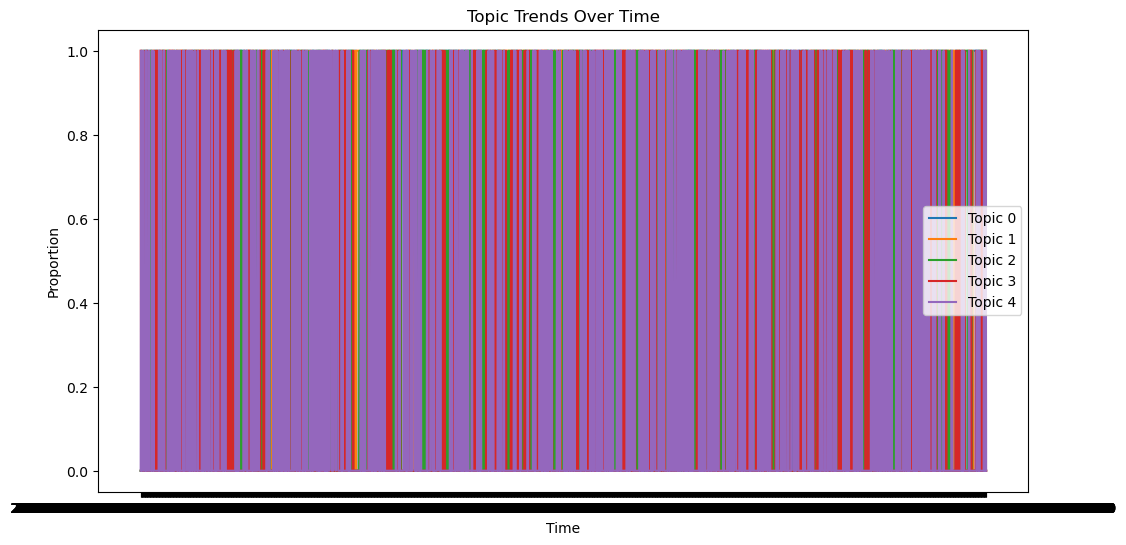

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate topic frequencies over time
topic_trends = chat_logs_df.groupby(['timestamp', 'dominant_topic']).size().unstack(fill_value=0)

# Normalize topic frequencies within each time bin to get proportions
topic_proportions = topic_trends.div(topic_trends.sum(axis=1), axis=0)

# Plotting
plt.figure(figsize=(12, 6))
for topic in topic_proportions.columns:
    plt.plot(topic_proportions.index, topic_proportions[topic], label=f'Topic {topic}')

plt.xlabel('Time')
plt.ylabel('Proportion')
plt.title('Topic Trends Over Time')
plt.legend()
plt.show()


In [63]:
# loop through all of the dominant topics, print out the top 5 messages for each, include the nick and timestamp
for topic in chat_logs_df['dominant_topic'].unique():
    print(f"Top messages for topic {topic}:")
    top_messages = chat_logs_df[chat_logs_df['dominant_topic'] == topic].sort_values(by='dominant_topic', ascending=False).head(5)
    #lets sort this by timestamp
    top_messages = top_messages.sort_values(by='timestamp', ascending=False)
    for index, row in top_messages.iterrows():
        # lets clean up the timestamp, we want YYYY-MM-DD HH:MM:SS
        row['timestamp'] = row['timestamp'].replace('T', ' ').split('.')[0]
        print(f"({row['timestamp']}) {row['user']}: {row['message']}")
    print("\n")

Top messages for topic 2:
(2024-04-10 23:46:32) leku: lol
(2024-04-10 23:28:17) sig: It's understandable to feel frustrated or distrustful toward media coverage if it seems biased or inconsistent. It’s critical for media outlets to strive for accuracy, fairness, and objectivity to maintain public trust. As consumers, it's also important to engage critically with news sources, seek out diverse perspectives, and use reputable information to form well-rounded views. Engaging in
(2024-04-10 23:28:12) Scaleb: sig: as much as you hate the media, its not enough
(2024-04-10 23:27:30) sig: When allegations or claims come from potentially sensitive sources like a personal diary, media outlets face additional ethical considerations. They need to verify the authenticity of the source and the information it contains. Even if the information appears to be in someone's own words, journalists must go through processes to ensure they are not spreading misinformation or violating privacy
(2024-03-31 15: